# Get Started with Keras 3.0 + MLflow

This tutorial is an end-to-end tutorial on training a MINST classifier with **Keras 3.0** and logging results with **MLflow**. It will demonstrate the use of `mlflow.keras_core.MLflowCallback`, and how to subclass it to implement custom logging logic.

**Keras** is a high-level api that is designed to be simple, flexible, and powerful - allowing everyone from beginners to advanced users to quickly build, train, and evaluate models. **Keras 3.0**, or Keras Core, is a full rewrite of the Keras codebase that rebases it on top of a modular backend architecture. It makes it possible to run Keras workflows on top of arbitrary frameworks — starting with TensorFlow, JAX, and PyTorch.

## Install Packages

`pip install -q keras-core mlflow jax jaxlib torch tensorflow`

## Import Packages / Configure Backend
Keras 3.0 is inherently multi-backend, so you will need to set the backend environment variable **before** importing the package.

In [13]:
import os

# You can use 'tensorflow', 'torch' or 'jax' as backend. Make sure to set the environment variable before importing.
os.environ["KERAS_BACKEND"] = "tensorflow"

In [14]:
import keras_core
import mlflow
from mlflow.keras_core import MLflowCallback
import numpy as np

## Load Dataset
We will use the MNIST dataset. This is a dataset of handwritten digits and will be used for an image classification task. There are 10 classes corresponding to the 10 digits.

In [15]:
(x_train, y_train), (x_test, y_test) = keras_core.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)
x_train[0].shape

(28, 28, 1)

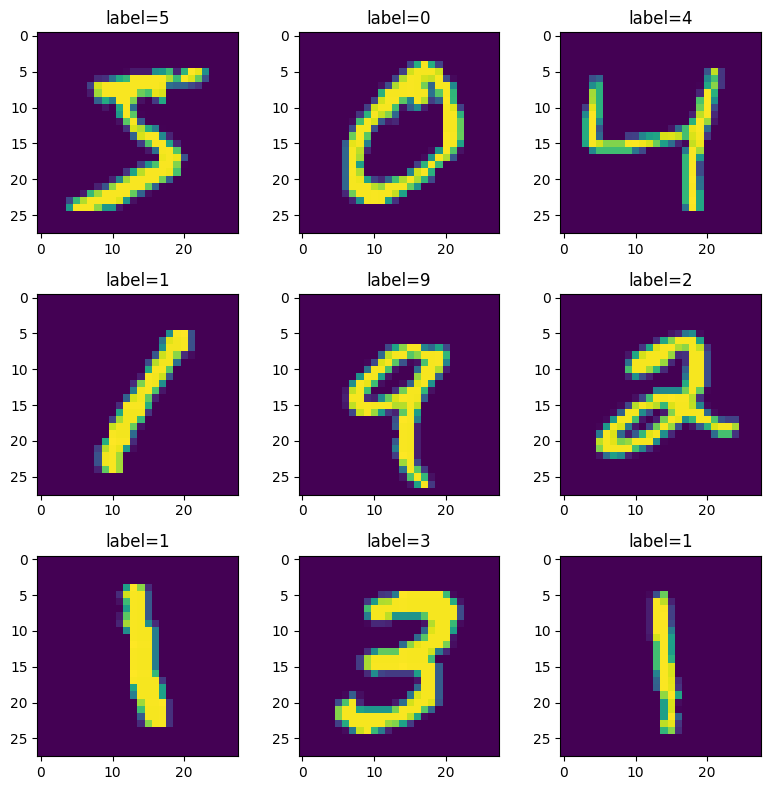

In [16]:
# Visualize Dataset
import matplotlib.pyplot as plt

grid = 3
fig, axes = plt.subplots(grid, grid, figsize=(8, 8))
for i in range(grid):
    for j in range(grid):
        axes[i][j].imshow(x_train[i * grid + j])
        axes[i][j].set_title(f"label={y_train[i * grid + j]}")
plt.tight_layout()

## Build Model
We will use the Keras 3.0 sequential API to build a simple CNN.

In [17]:
NUM_CLASSES = 10
INPUT_SHAPE = (28, 28, 1)


def initialize_model():
    model = keras_core.Sequential(
        [
            keras_core.Input(shape=INPUT_SHAPE),
            keras_core.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
            keras_core.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
            keras_core.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
            keras_core.layers.GlobalAveragePooling2D(),
            keras_core.layers.Dense(NUM_CLASSES, activation="softmax"),
        ]
    )
    return model


model = initialize_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)        │        320 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 32)        │      9,248 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_2 (Conv2D)               │ (None, 22, 22, 32)        │      9,248 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ global_average_pooling2d        │ (None, 32)                │          0 │
│ (GlobalAveragePooling2D)        │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense (Dense)                   │ (None, 10)                │        330 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 19,146 (74.79 KB)

 Trainable params: 19,146 (74.79 KB)

 Non-trainable params: 0 (0.00 B)

## Train Model (Default Callback)
We will fit the model on the dataset, using MLflow's `mlflow.keras_core.MLflowCallback` to log metrics during training.

In [18]:
BATCH_SIZE = 64  # adjust this based on the memory of your machine
EPOCHS = 3

### Log Per Epoch
An epoch defined as one pass through the entire training dataset.

In [19]:
model = initialize_model()

model.compile(
    loss=keras_core.losses.SparseCategoricalCrossentropy(),
    optimizer=keras_core.optimizers.Adam(),
    metrics=["accuracy"],
)

with mlflow.start_run() as run:
    model.fit(
        x_train,
        y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_split=0.1,
        callbacks=[mlflow.keras_core.MLflowCallback(run)],
    )

Epoch 1/3
844/844 ━━━━━━━━━━━━━━━━━━━━ 83s 99ms/step - accuracy: 0.5909 - loss: 1.4584 - val_accuracy: 0.9378 - val_loss: 0.2240
Epoch 2/3
844/844 ━━━━━━━━━━━━━━━━━━━━ 83s 98ms/step - accuracy: 0.9349 - loss: 0.2314 - val_accuracy: 0.9562 - val_loss: 0.1589
Epoch 3/3
844/844 ━━━━━━━━━━━━━━━━━━━━ 60s 71ms/step - accuracy: 0.9493 - loss: 0.1744 - val_accuracy: 0.9598 - val_loss: 0.1269


### Log Results
The callback for the run would log **parameters**, **metrics** and **artifacts** to MLflow dashboard.

![run page](https://i.imgur.com/YLGFDJE.png)

### Log Per Batch
Within each epoch, the training dataset is broken down to batches based on the defined `BATCH_SIZE`. If we set the callback to not log based on epochs with `log_every_epoch=False`, and to log every 5 batches with `log_every_n_steps=5`, we can adjust the logging to be based on the batches.

In [24]:
model = initialize_model()

model.compile(
    loss=keras_core.losses.SparseCategoricalCrossentropy(),
    optimizer=keras_core.optimizers.Adam(),
    metrics=["accuracy"],
)

with mlflow.start_run() as run:
    model.fit(
        x_train,
        y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_split=0.1,
        callbacks=[
            mlflow.keras_core.MLflowCallback(run, log_every_epoch=False, log_every_n_steps=5)
        ],
    )

Epoch 1/3
844/844 ━━━━━━━━━━━━━━━━━━━━ 58s 69ms/step - accuracy: 0.5788 - loss: 1.5714 - val_accuracy: 0.9220 - val_loss: 0.2735
Epoch 2/3
844/844 ━━━━━━━━━━━━━━━━━━━━ 58s 68ms/step - accuracy: 0.9256 - loss: 0.2601 - val_accuracy: 0.9552 - val_loss: 0.1564
Epoch 3/3
844/844 ━━━━━━━━━━━━━━━━━━━━ 59s 69ms/step - accuracy: 0.9460 - loss: 0.1892 - val_accuracy: 0.9563 - val_loss: 0.1449


### Log Results

If we **log per epoch**, we will only have three datapoints, since there are only 3 epochs:

![log per epoch](https://i.imgur.com/rFDj8SH.png)

By **logging per batch**, we can get more datapoints, but they can be noisier:

![log per batch](https://i.imgur.com/ZCYXLql.png)

## Train Model (Custom Callback)
Let's train the model again, for the purpose of demonstrating how to use subclass and customize MLflow's `mlflow.keras_core.MLflowCallback` for logging. 

The pre-defined `MLflowCallback` allows us to adjust whether we want to log every epoch or every batch through parameters `log_every_epoch` and `log_every_n_steps`. However, currently each time the callback logs is defined as a `step`, so if we log every 5 batches, it will just be 1 step. What if we want the steps to correspond exactly to the batches seen?

Notice that the logging that happens every 5 batches is logged as one step along the x-axis:

![5 Batches Per Step](https://i.imgur.com/RK1HotH.png?1)

The method we will look at is `on_batch_end()`. This method is a callback that is called at the end of every batch. `self._log_step` counts the logging steps and is shown as one of the x-axis on the graph.

```
def on_batch_end(self, batch, logs=None):
  """Log metrics at the end of each batch with user specified frequency."""
  if self.log_every_n_steps is None or logs is None:
      return
  if (batch + 1) % self.log_every_n_steps == 0:
      self.metrics_logger.record_metrics(logs, self._log_step)
      self._log_step += 1
```

In [25]:
class MlflowCallbackLogPerBatch(mlflow.keras_core.MLflowCallback):
    def on_batch_end(self, batch, logs=None):
        if self.log_every_n_steps is None or logs is None:
            return
        if (batch + 1) % self.log_every_n_steps == 0:
            self.metrics_logger.record_metrics(logs, self._log_step)
            self._log_step += self.log_every_n_steps

In [26]:
model = initialize_model()

model.compile(
    loss=keras_core.losses.SparseCategoricalCrossentropy(),
    optimizer=keras_core.optimizers.Adam(),
    metrics=["accuracy"],
)

with mlflow.start_run() as run:
    model.fit(
        x_train,
        y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_split=0.1,
        callbacks=[MlflowCallbackLogPerBatch(run, log_every_epoch=False, log_every_n_steps=5)],
    )

Epoch 1/3
844/844 ━━━━━━━━━━━━━━━━━━━━ 58s 69ms/step - accuracy: 0.5400 - loss: 1.5410 - val_accuracy: 0.8798 - val_loss: 0.4032
Epoch 2/3
844/844 ━━━━━━━━━━━━━━━━━━━━ 59s 70ms/step - accuracy: 0.9170 - loss: 0.2880 - val_accuracy: 0.9513 - val_loss: 0.1825
Epoch 3/3
844/844 ━━━━━━━━━━━━━━━━━━━━ 59s 70ms/step - accuracy: 0.9424 - loss: 0.1945 - val_accuracy: 0.9610 - val_loss: 0.1254


### Log Results

Observe that with the customized callback, the steps correspond directly to the number of batches seen. 1 batch corresponds to 1 step.

![1 batch per step](https://i.imgur.com/hhO178j.png?1)

## Evaluation
Similar to training, you can use the callback to log the evaluation result.

In [27]:
with mlflow.start_run() as run:
    model.evaluate(x_test, y_test, callbacks=[mlflow.keras_core.MLflowCallback(run)])

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9503 - loss: 0.1721
